Maze Environment, solving policies, AI and Policy comparison metrics
_______________________________________________________________________________________________________________________________
This notebook contains maze environment generator, as well as metrics to compare efficiency of policies(number of steps needed to achieve goal state, mean of nosntags on succesful trials), allowing the user to see the difference between pre-written(scripted) plans, policies, random policies , probability policies, Dijkstra shortest path algorithm, and deep q learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import random
import time
import math

from IPython.display import clear_output

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
#from callbacks import ModifiedTensorBoard#             edit Tensorflow class TensorBoard
from collections import deque

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
REPLAY_MEMORY_SIZE = 1000

In [5]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [6]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [7]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [8]:
%matplotlib inline

In [9]:
#Policy1 for agent movement
def decision_maker():
    if (random.randint(1,10)) > 3:
        if random.randint(1,10) >5:
            return 1
        else:
            return 3
    else:
        if random.randint(1,10) >5:
            return 2
        else:
            return 4
    

In [10]:
#Policy2 for agent movement
def decision_maker_smarter(p0,p1,p2,p3):
    if p0 != 1 and p2 !=1:
        if random.randint(1,10) >5:
            return 1
        else:
            return 3
    if p0 != 1 or p2 !=1:
        if random.randint(1,10) >3:
            if random.randint(1,10) >5:
                return 1
            else:
                return 3
        else:
            if random.randint(1,10) >5:
                return 2
            else:
                return 4
        
    else:
        if random.randint(1,10) >5:
            return 2
        else:
            return 4
    

In [11]:
#Policy2 for agent movement(that expects agent to start at the bottom right of the map)
def decision_maker_smarter_inverse(p0,p1,p2,p3):
    if p1 != 1 and p2 !=1:
        if random.randint(1,10) >5:
            return 2
        else:
            return 4
    if p1 != 1 or p3 !=1:
        if random.randint(1,10) >3:
            if random.randint(1,10) >5:
                return 2
            else:
                return 4
        else:
            if random.randint(1,10) >5:
                return 1
            else:
                return 3
        
    else:
        if random.randint(1,10) >5:
            return 1
        else:
            return 3

In [12]:
#Conditions for randomized map drawing
def conditioner(i,j,arr):
    rules = [arr[i+1][j] == 1 and arr[i-1][j] == 1 and arr[i][j-1] == 1,
            arr[i][j-1] == 1 and arr[i][j+1] and arr[i+1][j] == 1 ]
    return rules

In [13]:
class Agent():
    def __init__(self, location):
        self.location = location
        
    def move(self, x):
        if x == 1:
            self.location[0] = self.location[0] + 1
        if x == 2:
            self.location[0] = self.location[0] - 1
        if x == 3: 
            self.location[1] = self.location[1] + 1
        if x == 4:
            self.location[1] = self.location[1] - 1
            

In [14]:
class Environment():
    def __init__(self, size, steps, animated,display, open_map):
        
        #size: Map that will be generated is always square type, expects integer.
        
        #steps: Number of actions that agent is allowed to take , expects integer.
        
        #animated: Determines wether or not actions of the agent will be animated, expects boolean. note: If False, image output
        #will be that of the final state (upon reaching maximum number of steps)
        
        #display: Determines wether or not actions of the agent will be displayed at all, expects boolean.
        
        #open map: empty map(no walls) if True or generated map if False.
        
        self.open_map = open_map
        movement_plan = [1,2,1,2,2,2,1,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,3,4,2,1,2,2,1]
        self.size = size
        self.steps = steps
        #q-learning
        self.living_penalty = -0.1
        self.gamma = 0.5
        self.perception_field_rewards = [None,None,None,None]
        #Perception vectors (see method "perception" for better description)
        self.perception_field = [None,None,None,None]
        self.perception_field2 = [None,None,None,None]
        
        #Create a map and set up the agents, then run the plan/policy.
        self.map = np.random.randint(0,2, (size,size))
        self.recorded = []
        self.display = display
#       self.map[30,30] = 4
        self.map_maker()
        self.agent = Agent([4,4])
        self.agent2 = Agent([len(self.map)-4,len(self.map)-4])
        self.map[self.agent.location[0], self.agent.location[1] ] = 3
        self.map[self.agent2.location[0], self.agent2.location[1] ] = 4
        self.run_plan(movement_plan, animated)
        
        

        
    
    def map_maker(self):
        #Generate randomized map
        # *See function: "conditioner"
        for i in range(len(self.map)):
            for j in range(len(self.map)):
                if i > 1 and j > 1 and i<len(self.map)-1  and j<len(self.map)-1:
                    if any(conditioner(i,j,self.map)):
                        self.map[i+1,j] = 0
                        if random.randint(0,10) > 5:
                            self.map[i][j+1] = 0
                        if random.randint(0,10) > 5:
                            self.map[i-1][j] = 0
                        self.map[i-1][j] = 0
      
        if self.open_map == True:
            self.map = np.zeros([self.size,self.size])
        self.map[0:(len(self.map)-1), 0] = 1
        self.map[0, 0:(len(self.map)-1)] = 1
        self.map[0:(len(self.map)-1), (len(self.map)-1)] = 1
        self.map[(len(self.map)-1),0:(len(self.map)-1)] = 1  
        
        
    def refresh(self, agent_input, agent2_input):
        
       # Refresh the map state if agent chooses a legal action
    
       # First agent 
        if agent_input == 1 and self.perception_field[0] != 1 :
            self.map[self.agent.location[0], self.agent.location[1]] = -1
            self.agent.move(1)
            self.map[self.agent.location[0], self.agent.location[1]] = 3
        if agent_input == 2 and self.perception_field[1] != 1:
            self.map[self.agent.location[0], self.agent.location[1]] = -1
            self.agent.move(2)
            self.map[self.agent.location[0], self.agent.location[1]] = 3
        if agent_input == 3 and self.perception_field[2] != 1 :
            self.map[self.agent.location[0], self.agent.location[1]] = -1
            self.agent.move(3)
            self.map[self.agent.location[0], self.agent.location[1]] = 3
        if agent_input == 4 and self.perception_field[3] != 1 :
            self.map[self.agent.location[0], self.agent.location[1]] = -1
            self.agent.move(4)
            self.map[self.agent.location[0], self.agent.location[1]] = 3
            
        #Second agent    
        if agent2_input == 1 and self.perception_field2[0] != 1 :
            self.map[self.agent2.location[0], self.agent2.location[1]] = -2
            self.agent2.move(1)
            self.map[self.agent2.location[0], self.agent2.location[1]] = 4
        if agent2_input == 2 and self.perception_field2[1] != 1:
            self.map[self.agent2.location[0], self.agent2.location[1]] = -2
            self.agent2.move(2)
            self.map[self.agent2.location[0], self.agent2.location[1]] = 4
        if agent2_input == 3 and self.perception_field2[2] != 1 :
            self.map[self.agent2.location[0], self.agent2.location[1]] = -2
            self.agent2.move(3)
            self.map[self.agent2.location[0], self.agent2.location[1]] = 4
        if agent2_input == 4 and self.perception_field2[3] != 1 :
            self.map[self.agent2.location[0], self.agent2.location[1]] = -2
            self.agent2.move(4)
            self.map[self.agent2.location[0], self.agent2.location[1]] = 4
        
    def run_plan(self, plan, animated):
        
        #Run the plan/policy for agent movement, then display the distance of each agent from it's goal
        #Plan expects vectors of consecutive actions, although policies are used in all examples.
        for i in range(0,self.steps):#plan:
            
            
            self.perception2()
            self.perception()
            #self.refresh(decision_maker_smarter(self.perception_field[0],self.perception_field[1],self.perception_field[2],self.perception_field[3]),decision_maker_smarter_inverse(self.perception_field2[0],self.perception_field2[1],self.perception_field2[2],self.perception_field2[3]))
            #self.refresh(decision_maker_smarter(self.perception_field[0],self.perception_field[1],self.perception_field[2],self.perception_field[3]),decision_maker_smarter_inverse(self.perception_field2[0],self.perception_field2[1],self.perception_field2[2],self.perception_field2[3]))     
            self.refresh(decision_maker(),decision_maker_smarter_inverse(self.perception_field2[0],self.perception_field2[1],self.perception_field2[2],self.perception_field2[3]))        
            self.recorded.append(self.map)
                
            if animated == True:
                plt.imshow(self.map, cmap="rainbow", animated = False)
                plt.show()
                time.sleep(0.05)
                clear_output(wait=True)
            
            #for instant final state
        if self.display == True:
            
            plt.imshow(self.map, cmap="rainbow", animated = False)
            plt.show()
            print("Blue,Purple")
            print(self.distance([len(self.map)-1,len(self.map)-1],[0,0]))
                  
    def output_state(self):
        
        return [self.agent.location[0],self.agent.location[1],self.perception_field[0],self.perception_field[1],self.perception_field[2],self.perception_field[3], self.distance([30,30])]
    # x,y,distance from goal,cross_perception
        
    def perception(self):
        
        
        #Refreshes the values in the perception vector of the first agent(starts at top left)
        
        #Sets the perception_field vector values to those that match the new state of the agent. Perception_field array contains
        #the values of neighbouring points(relative to the position of the agent) , these are used to determine if the action
        #that happens to be chosen by the agent is legal(there is no wall). If conditions are met, action will affect the next state of the environment.
        
        self.perception_field[0] = self.map[self.agent.location[0]+1, self.agent.location[1]]
        
        self.perception_field[1] = self.map[self.agent.location[0]-1, self.agent.location[1]]
        
        self.perception_field[2] = self.map[self.agent.location[0], self.agent.location[1]+1]
        
        self.perception_field[3] = self.map[self.agent.location[0], self.agent.location[1]-1]
        
    def perception_rewards(self, reward_map):
        
        # Perception vector of the reward map
        
        self.perception_field_rewards[0] = reward_map[self.agent.location[0]+1, self.agent.location[1]]
        
        self.perception_field_rewards[1] = reward_map[self.agent.location[0]-1, self.agent.location[1]]
        
        self.perception_field_rewards[2] = reward_map[self.agent.location[0], self.agent.location[1]+1]
        
        self.perception_field_rewards[3] = reward_map[self.agent.location[0], self.agent.location[1]-1]
        
    def perception2(self):
        
        #Refreshes the values in the perception vector of the second agent(starts at bottom right)
        
        #Sets the perception_field vector values to those that match the new state of the agent. Perception_field array contains
        #the values of neighbouring points(relative to the position of the agent) , these are used to determine if the action
        #that happens to be chosen by the agent is legal. If conditions are met, action will affect the next state of the environment.
        
        self.perception_field2[0] = self.map[self.agent2.location[0]+1, self.agent2.location[1]]
        
        self.perception_field2[1] = self.map[self.agent2.location[0]-1, self.agent2.location[1]]
        
        self.perception_field2[2] = self.map[self.agent2.location[0], self.agent2.location[1]+1]
        
        self.perception_field2[3] = self.map[self.agent2.location[0], self.agent2.location[1]-1]
    
    def distance(self,goal,goal2):
        #goal is [x,y]
        #self.map[goal] = 4
        return ((goal[0] - self.agent.location[0]) + (goal[1]- self.agent.location[1] ), abs((goal2[0] - self.agent2.location[0]) + (goal2[1]- self.agent2.location[1] )))
    
    def distance_rewards(self,goal,i):
        
        #goal is [x,y]
        #self.map[goal] = 4
        if i == 0:
            return ((goal[0] - (1+self.agent.location[0])) + (goal[1]- self.agent.location[1] ))
        if i == 1:
            return ((goal[0] - (self.agent.location[0]-1)) + (goal[1]- self.agent.location[1] ))
        if i == 2:
            return ((goal[0] - (self.agent.location[0])) + (goal[1]- self.agent.location[1]+1 ))
        if i == 3:
            return ((goal[0] - (self.agent.location[0])) + (goal[1]- self.agent.location[1]-1 ))
    
    def reward_states_map(self, goal, living_penalty, gamma_discount):
        # goal expects [-y,x]
        # Generate reward map for all possible states, essentialy this is a q-table.
        
        arr = np.zeros([len(self.map),len(self.map)])
        for i in range(len(self.map)):
            for j in range(len(self.map)):
                
                # if cell is already visited
                if self.map[i][j] == -1:
                    arr[i][j] = (-0.6 + (living_penalty))
                
                # if cell is blocked
                if self.map[i][j] == 1:
                    arr[i][j] = (-0.9 + (living_penalty))
                    
                # if agent reached the goal state
                if self.map[goal[0],goal[1]] == 3:
                    arr[i][j] = (1)
                    
                arr[i][j] = arr[i][j] - ((self.distance_rewards([i,j]))/(math.sqrt(self.size**2 + self.size**2))) *gamma_discount
                
        return arr
                
            
    def reward_calculator(self):
        
        # Calculate the value of a certain state based on the conditions provided.
        arr = [0,0,0,0]
        for i in range(len(self.perception_field)):
            
            # if cell is already visited
            if self.perception_field[i] == -1:
                arr[i] = (-4 + (self.living_penalty))
                
            # if cell is blocked
            if self.perception_field[i] == 1:
                arr[i] = (-6 + (self.living_penalty))
                    
                # if agent reached the goal state
                #if self.map[goal[0],goal[1]] == 3:
                #    arr[i] = (1)
                
            
            
            
            arr[i] = arr[i] + ((self.distance_rewards([40,40],i))//(math.sqrt(self.size**2 + self.size**2))) *self.gamma + (self.living_penalty)
        return arr

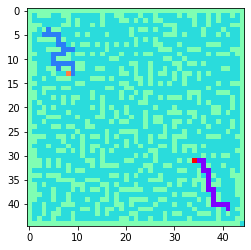

Blue,Purple
(67, 65)


In [17]:
env = Environment(size=45, steps=55, animated=True, display=True, open_map=False)


In [15]:
import pandas as pd

In [16]:
#Creates a sample of maze runs on randomized maps, used to compare efficiency of  policies/plans.
def sample(envsize, sample_size,animated1,display1, openmap):
    sample_data = np.zeros(((sample_size),3))
    for i in range(len(sample_data)):
        stepsize= random.randint(envsize+0.2*envsize,envsize*20)
        env = Environment(envsize,stepsize,animated=animated1, display=display1, open_map=openmap)
        #sample_data[i] = [stepsize, sum(env.distance([len(env.map)-1,len(env.map)-1],[0,0]))]
        sample_data[i] = [stepsize, env.distance([len(env.map)-1,len(env.map)-1],[0,0])[0],env.distance([len(env.map)-1,len(env.map)-1],[0,0])[1]]                                        
    return pd.DataFrame(sample_data)

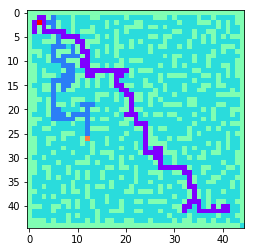

Blue,Purple
(50, 4)


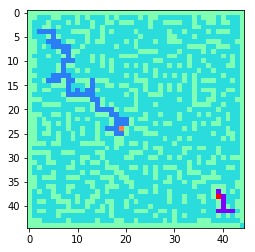

Blue,Purple
(45, 77)


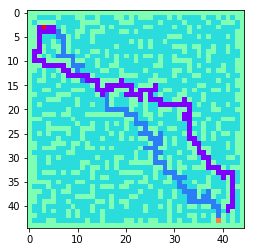

Blue,Purple
(6, 6)


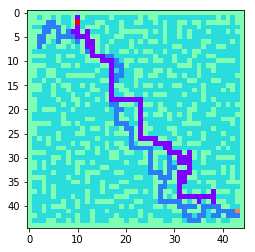

Blue,Purple
(4, 12)


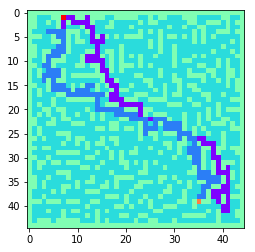

Blue,Purple
(14, 8)


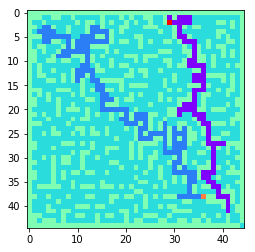

Blue,Purple
(14, 31)


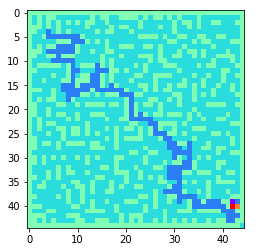

Blue,Purple
(5, 82)


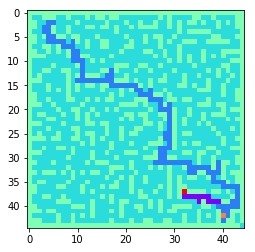

Blue,Purple
(6, 69)


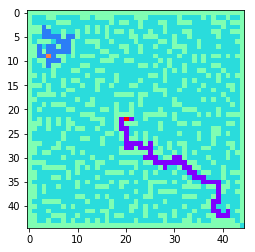

Blue,Purple
(75, 42)


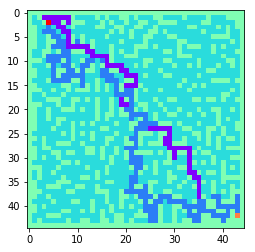

Blue,Purple
(3, 6)


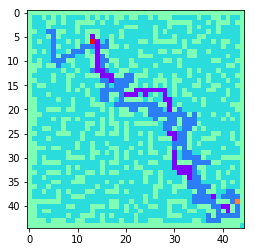

Blue,Purple
(6, 19)


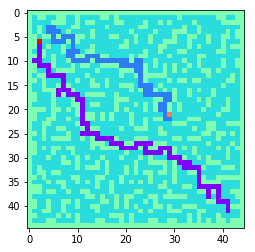

Blue,Purple
(38, 8)


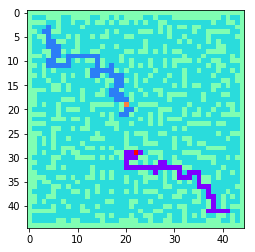

Blue,Purple
(49, 51)


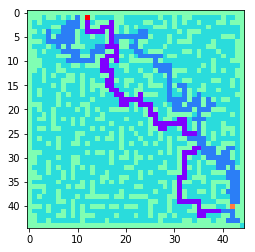

Blue,Purple
(6, 13)


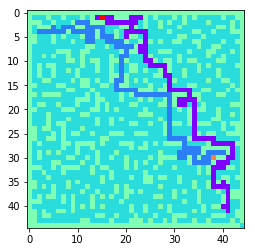

Blue,Purple
(20, 16)


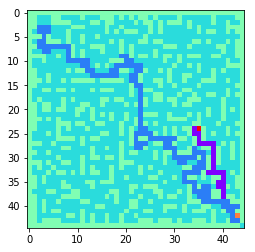

Blue,Purple
(3, 59)


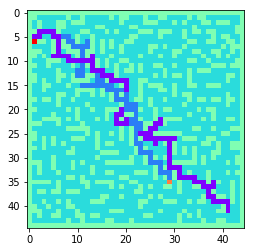

Blue,Purple
(24, 7)


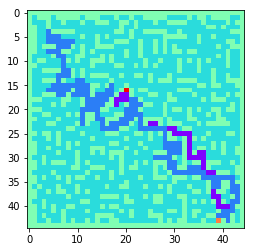

Blue,Purple
(6, 36)


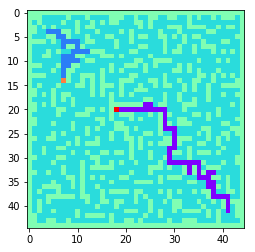

Blue,Purple
(67, 38)


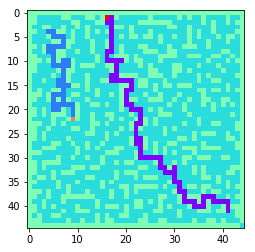

Blue,Purple
(57, 17)


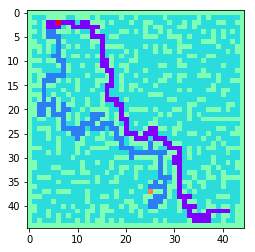

Blue,Purple
(26, 8)


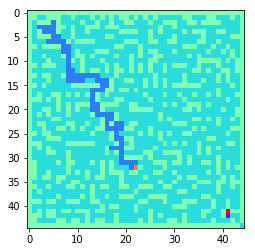

Blue,Purple
(34, 82)


,0,1,2
0,295.0,50.0,4.0
1,405.0,45.0,77.0
2,433.0,6.0,6.0
3,426.0,4.0,12.0
4,611.0,14.0,8.0
5,600.0,14.0,31.0
6,562.0,5.0,82.0
7,354.0,6.0,69.0
8,230.0,75.0,42.0
9,842.0,3.0,6.0


In [17]:
sample(45,22, False, True, False)

In [21]:
Sample1 = sample(50, 1555, animated1 = False, display1 = False, openmap = False)

AxesSubplot(0.125,0.125;0.775x0.755)


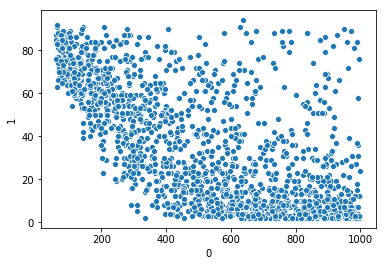

In [24]:
print(sns.scatterplot(Sample1[0],Sample1[1]))
# X = number of steps allowed, Y=distance from final state (agent1)

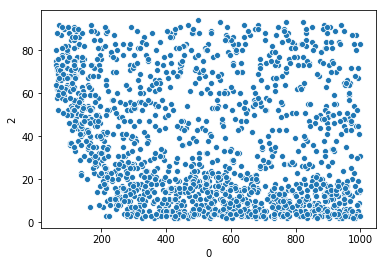

In [25]:
sns.scatterplot(Sample1[0],Sample1[2])
# X = number of steps allowed, Y=distance from final state (agent2)

In [42]:
# IDeja : odsjeci dataset da samo pokazuje ove nakon konvergencije, da se moze vizualizirati varijanca i uraditi statisticki test

In [ ]:
DQNAGENT

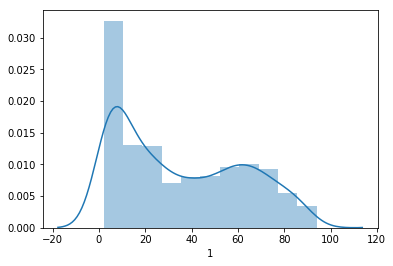

In [27]:
sns.distplot(Sample1[1])

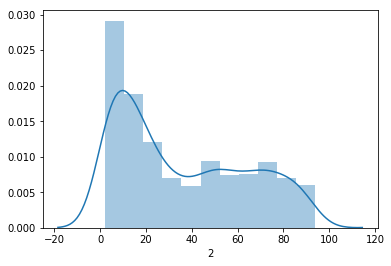

In [28]:
sns.distplot(Sample1[2])

In [29]:
legit_steps1 = Sample1[0] < 220

In [30]:
legit_steps2 = Sample1[0] > 200

In [31]:
succesful = Sample1[2] < 10

In [34]:
Sample1

,0,1,2
0,429.0,3.0,3.0
1,864.0,2.0,2.0
2,288.0,4.0,4.0
3,129.0,12.0,4.0
4,25.0,95.0,97.0
5,350.0,3.0,3.0
6,221.0,2.0,3.0
7,1097.0,3.0,3.0
8,640.0,4.0,2.0
9,579.0,4.0,2.0


In [36]:
np.mean(Sample1[legit_steps2][1])

28.60906298003072

In [37]:
np.mean(Sample1[succesful][1])

24.24641833810888